In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import missingno as msno
import seaborn as sns
from fbprophet import Prophet
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
! pip install bar_chart_race
import bar_chart_race as bcr

     |████████████████████████████████| 156 kB 4.3 MB/s 


In [3]:
data = pd.read_csv('../input/windows-store/msft.csv', parse_dates=['Date'])
data.dropna(inplace=True)
data.tail()

,Name,Rating,No of people Rated,Category,Date,Price
5316,Get Color,3.0,785,Developer Tools,2019-08-08,₹ 54.50
5317,JS King,1.0,720,Developer Tools,2018-07-19,₹ 269.00
5318,MQTTSniffer,2.5,500,Developer Tools,2017-10-04,₹ 64.00
5319,"Dev Utils - JSON, CSV and XML",4.0,862,Developer Tools,2019-11-18,₹ 269.00
5320,Simply Text,4.0,386,Developer Tools,2014-01-23,₹ 219.00


In [4]:
data.columns

Index(['Name', 'Rating', 'No of people Rated', 'Category', 'Date', 'Price'], dtype='object')

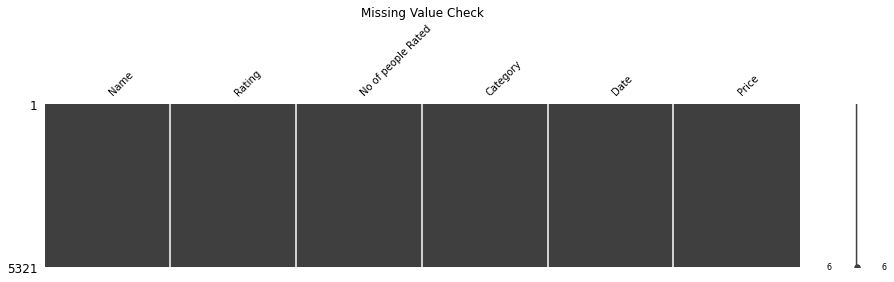

In [5]:
msno.matrix(data, figsize=(15, 3), fontsize=10)
plt.title('Missing Value Check')
plt.show()

NO Missing Value

## Bar Char Race

In [6]:
df = data.groupby([data.Date.dt.strftime('%Y-%m'), 'Category']).size().unstack().fillna(0).cumsum()
df.set_index(pd.to_datetime(df.index), inplace=True)

def summary(values, ranks):
    total_apps = values.sum()
    s = f'Total APPS - {total_apps:,.0f}'
    return {'x': .92, 'y': .05, 's': s, 'ha': 'right', 'size': 8}


bcr.bar_chart_race(df,
                   title='Category Count Race',
                   steps_per_period=10,
                   period_length=800,
                   period_summary_func=summary,
                   period_fmt='%b, %Y',
                   interpolate_period=True,
                   )

## CATEGORY

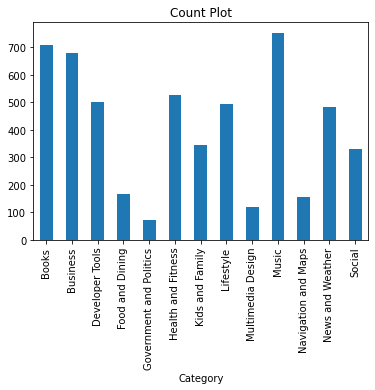

In [7]:
data.groupby('Category').size().plot(kind='bar', title='Count Plot')
plt.show()

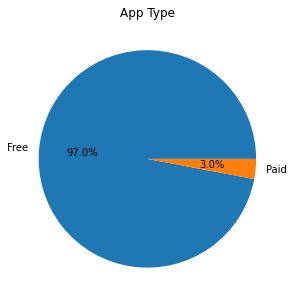

In [8]:
data['Price_type'] = data.Price.apply(
    lambda x: "Free" if x == "Free" else 'Paid')
df = data.Price_type.value_counts(normalize=True)*100
df.plot.pie(title='App Type',
            autopct=lambda x: f"{round(x, 1)}%", figsize=(5, 5)).set(ylabel="")
plt.show()

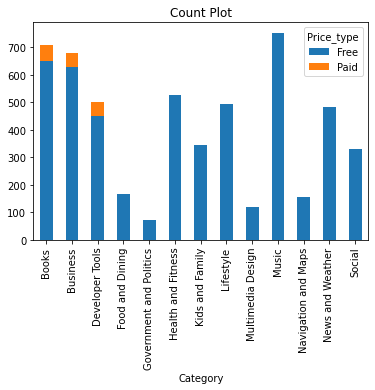

In [9]:
data.groupby(['Category', 'Price_type']).size().unstack().plot(
    kind='bar', stacked=True, title="Count Plot")
plt.show()

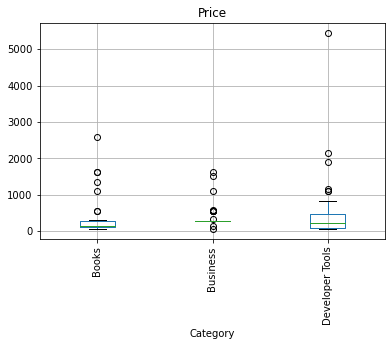

In [10]:
df = data.query('Price_type == "Paid"').reset_index()
df.Price = df.Price.str.split().apply(
    lambda x: x[1].replace(",", "")).astype('float')

df.boxplot('Price', 'Category', rot=90, grid=True,  return_type='axes')
plt.suptitle('')
plt.show()

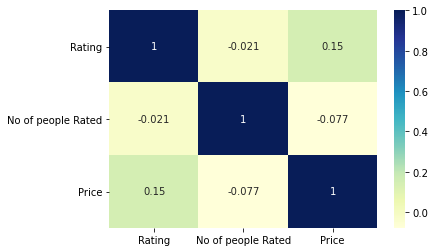

In [11]:
sns.heatmap(df.loc[:, ['Rating', 'No of people Rated',
                       'Price']].corr(),  cmap="YlGnBu",  annot=True)
plt.show()

NO strong Correlation between Rating, people rated and Price

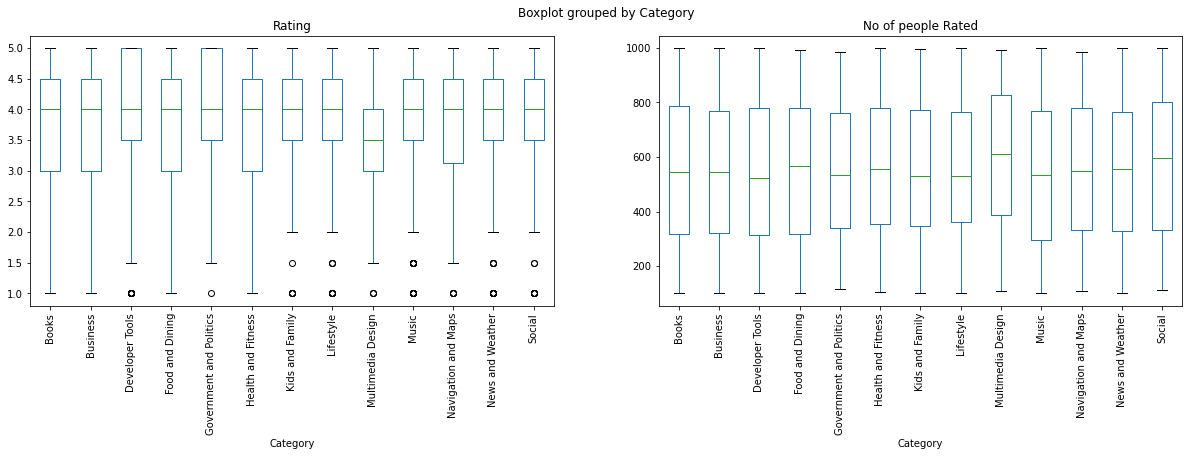

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
data.boxplot('Rating', 'Category', ax=ax[0], grid=False, rot=90)
data.boxplot('No of people Rated', 'Category', ax=ax[1], grid=False, rot=90)
plt.show()

## Date

In [13]:
data['months'] = data.Date.dt.strftime("%m")

data['date_num'] = data.Date.dt.strftime('%d')

data['day'] = data.Date.dt.strftime('%A')

data['year'] = data.Date.dt.strftime('%Y')

In [14]:
data.year = data.year.astype('int')
data.months = data.months.astype('int')
data.date_num = data.date_num.astype('int')

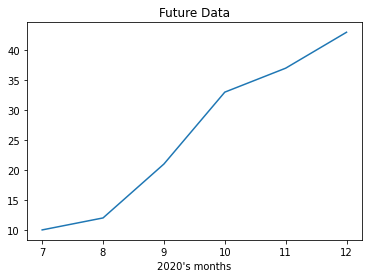

In [15]:
data.query('year == 2020 and months > 6').months.value_counts().sort_index().cumsum().plot(title = 'Future Data').set(xlabel = "2020's months")
plt.show()

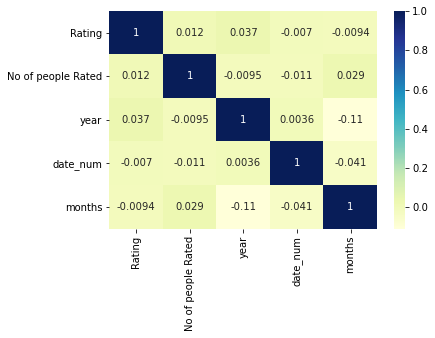

In [16]:
sns.heatmap(data.loc[:, ['Rating', 'No of people Rated', 'year',
                         'day', 'date_num', 'months']].corr(),  cmap="YlGnBu",   annot=True)
plt.show()

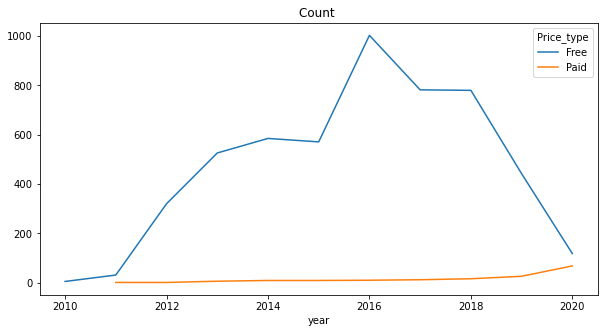

In [17]:
data.groupby(['year', 'Price_type']).size().unstack().plot(
    kind='line', figsize=(10, 5), title='Count ')
plt.show()

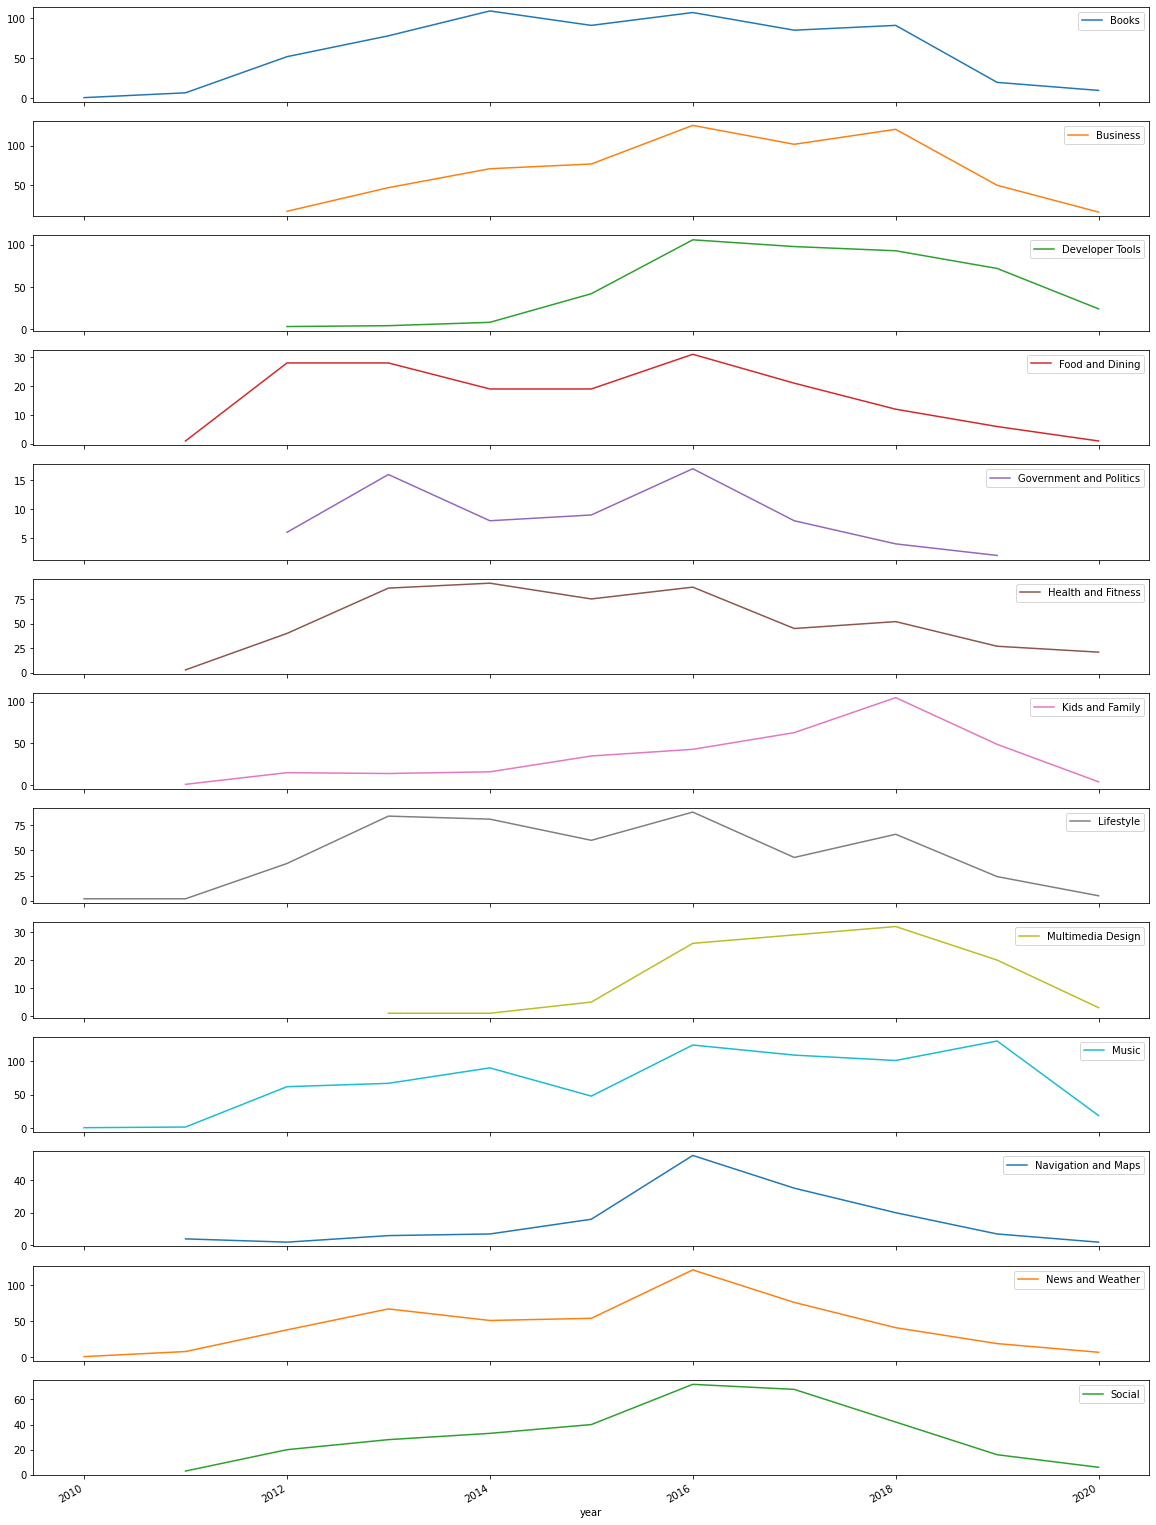

In [18]:
data.query('Price_type == "Free"').groupby(['year', 'Category']).size(
).unstack().plot(kind='line', figsize=(20, 30), subplots=True)
plt.show()

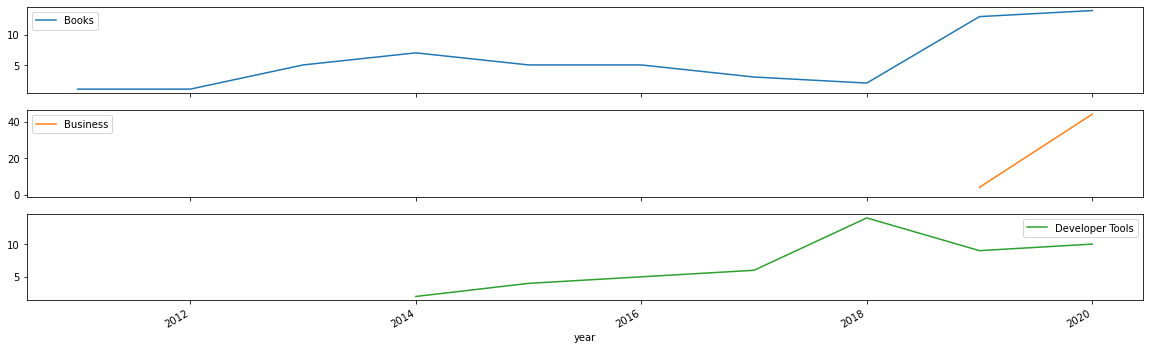

In [19]:
data.query('Price_type == "Paid"').groupby(['year', 'Category']).size(
).unstack().plot(kind='line', figsize=(20, 6), subplots=True)
plt.show()

In [20]:
df = data.sort_values(['Category', 'Date']).reset_index()
df["date_diff"] = df.Date.diff() / np.timedelta64(1, 'D')
df.drop(df.query('date_diff < 0').index, inplace=True)

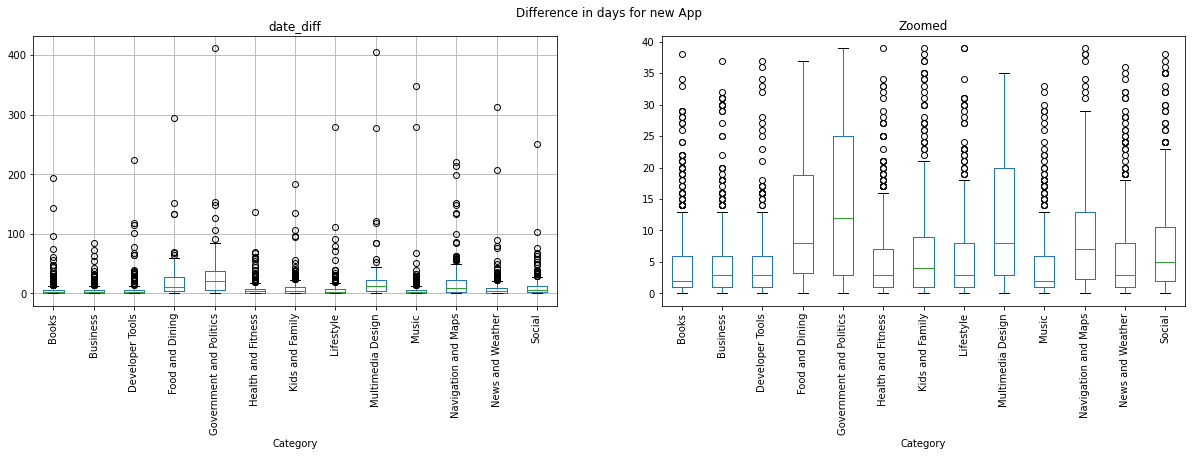

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df.query('year > 2010').boxplot(
    'date_diff', 'Category', ax=ax[0], rot=90)

df.query('year > 2010 and date_diff <40').boxplot(
    'date_diff', 'Category', ax=ax[1], grid=False, rot=90)

plt.title('Zoomed')
plt.suptitle('Difference in days for new App')
plt.show()

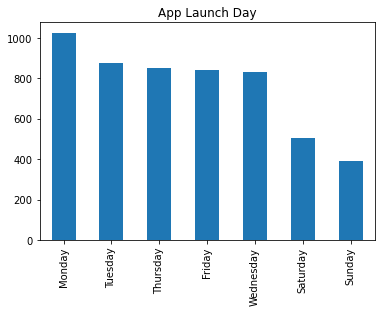

In [22]:
data.day.value_counts().plot.bar(title='App Launch Day')
plt.show()

### prediction

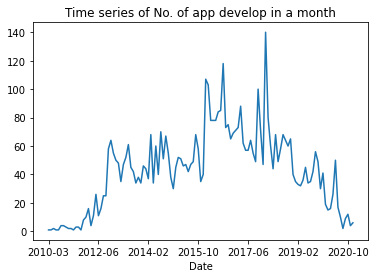

In [23]:
df = data.groupby(data.Date.dt.strftime('%Y-%m')).size()
df.plot(title = 'Time series of No. of app develop in a month')
plt.show()

df = df.reset_index()
df.columns=["ds","y"]

In [24]:
model=Prophet()
model.fit(df)
future_dates=model.make_future_dataframe(periods=30,freq = 'M' )
prediction=model.predict(future_dates)
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
148,2023-01-31,-9.453555,-25.799527,13.892164,-13.982095,-4.293101,4.284130,4.284130,4.284130,4.284130,4.284130,4.284130,0.0,0.0,0.0,-5.169425
149,2023-02-28,-10.535095,-25.460547,15.195469,-15.316979,-5.025753,4.870887,4.870887,4.870887,4.870887,4.870887,4.870887,0.0,0.0,0.0,-5.664208
150,2023-03-31,-11.732515,-38.383300,2.775070,-16.779604,-5.801353,-7.277327,-7.277327,-7.277327,-7.277327,-7.277327,-7.277327,0.0,0.0,0.0,-19.009842
151,2023-04-30,-12.891308,-28.071736,12.364212,-18.228721,-6.544312,4.233809,4.233809,4.233809,4.233809,4.233809,4.233809,0.0,0.0,0.0,-8.657499
152,2023-05-31,-14.088728,-43.491466,-4.033016,-19.775210,-7.454673,-9.350309,-9.350309,-9.350309,-9.350309,-9.350309,-9.350309,0.0,0.0,0.0,-23.439037


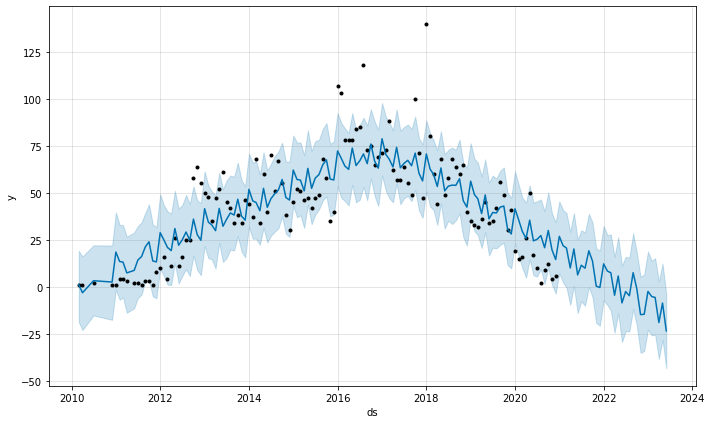

In [25]:
fig1 = model.plot(prediction)

At the end of 2021, there will be the end of app development in window store!!!!!!!!

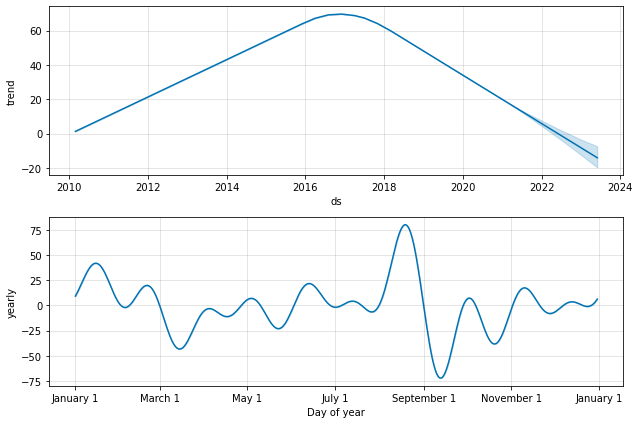

In [26]:
fig2 = model.plot_components(prediction)

According to trend the peak of app development in window store was in year 2017, after that it decreasing continuously

## People Rated

In [27]:
data.groupby(['Price_type']).agg({'No of people Rated': ['sum','count','mean', 'median']})

No of people Rated                         
                          sum count        mean median
Price_type                                            
Free                  2849739  5163  551.954096    548
Paid                    86382   158  546.721519    533

On an average people rated pretty much equal in both type of APP

In [28]:
data.groupby(['Price_type', 'Rating']).agg({'No of people Rated': ['sum','count','mean', 'median']})

No of people Rated                         
                                 sum count        mean median
Price_type Rating                                            
Free       1.0                 76216   143  532.979021  546.0
           1.5                 26691    48  556.062500  562.0
           2.0                 85750   146  587.328767  604.5
           2.5                140760   268  525.223881  509.0
           3.0                326260   605  539.272727  521.0
           3.5                460451   831  554.092659  543.0
           4.0                709758  1276  556.236677  558.5
           4.5                496446   890  557.804494  562.0
           5.0                527407   956  551.680962  550.0
Paid       1.0                 32604    58  562.137931  562.0
           1.5                  8482    14  605.857143  661.5
           2.0                  5256    10  525.600000  478.0
           2.5                  3724     8  465.500000  401.0
           3.0                  4684    10  468.400000  382.5
           3.5                  7162    13  550.923077  551.0
           4.0                 10988    23  477.739130  386.0
           4.5                  5687    10  568.700000  638.0
           5.0                  7795    12  649.583333  626.5

If we compare 5.0 rating of Free and Paid App, average people rating is 100 higher

## Name

There are 21524 words in the combination of all Music App Name.


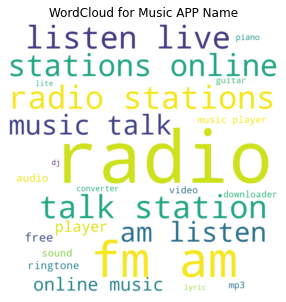

In [29]:
def wordcloudplot(category):
    stopwords = set(STOPWORDS)
    text = " ".join(review for review in data[data.Category == category].Name.str.lower())
    text = text.replace('by', "").replace('and', "")
    print(f"There are {len(text)} words in the combination of all {category} App Name.")

    wordcloud = WordCloud(width=800, height=800, background_color='white',max_words=150,prefer_horizontal=1,
                          stopwords=stopwords, min_font_size=20).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'WordCloud for {category} APP Name')
    plt.tight_layout(pad=0)
    plt.show()


category = 'Music'
wordcloudplot(category)

There are 15032 words in the combination of all Books App Name.


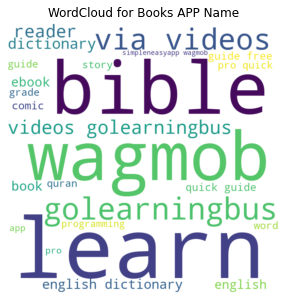

In [30]:
category = 'Books'
wordcloudplot(category)

There are 5281 words in the combination of all Social App Name.


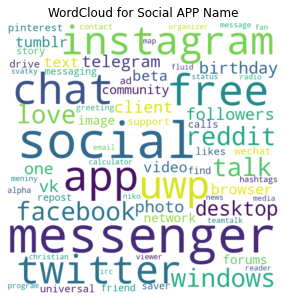

In [31]:
category = 'Social'
wordcloudplot(category)